In [3]:
%matplotlib inline

import pyvisa
import numpy as np
from pylabnet.utils.logging.logger import LogClient
import pylabnet.hardware.spectrum_analyzer.agilent_e4405B as sa
from pylabnet.network.client_server.agilent_e4405B import Client
import matplotlib.pyplot as plt

# Instantiate and Connect Client

In [6]:
sa_client = Client(
    host='localhost',
    port=12352
)

# Test Spectrum Analyzer Functionality

In [ ]:
# Turn off display.
sa_client.display_off()

In [ ]:
# Turn on display.
sa_client.display_on()

## Background acquisition

Let's acquire a background trace which can be used to normalize the power spectrum with respect to the noise floor. 

In [ ]:
# Try to retrieve the background --> Will fail.
background = sa_client.get_background()

Let's setup the spectrum analyzer to measure the frequency span of 11.7 GHz - 12.3 GHz:

In [ ]:
# Center frequency at 12 GHz.
center_freq = 12 # in GHz
sa_client.set_center_frequency(center_freq*1e9)

# Set trace span to 1 GHz.
freq_span = 1 # in GHz
sa_client.set_frequency_span(freq_span*1e9)

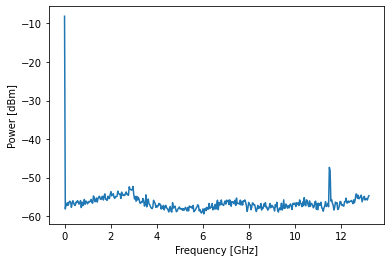

In [7]:
sa_client.plot_trace()

In [ ]:
# Now let's acquire this trace 100 times and save the average trace.
sa_client.acquire_background_spectrum(num_point=100, nocheck=False)

In [ ]:
# Now, we can retrieve the background trace, or plot it.
background = sa_client.get_background()
sa_client.plot_background()

## Trace plotting and background substraction

Now that the background spectrum is acquired, we can switch on the signal sources, in this case the output of a single-sideband upconversion setup.

In [ ]:
# Read and plot trace after swichting on the sources.
trace = sa_client.plot_trace()

In [ ]:
# Plot it with the background spectrum substracted (note the y-axis)
trace = sa_client.plot_trace(background_substract=True)

We can also use arbitrary IEEE Common Commands defined for the E4405B (see [programming manual](https://literature.cdn.keysight.com/litweb/pdf/E4401-90507.pdf)).

In [ ]:
# Set to single run mode using a write command.
command = 'INIT:CONT 0'
sa_client.write(command)

In [ ]:
# Check run mode using a query command.
command = 'INIT:CONT?'
sa_client.query(command)

# Markers

If only the  peak power for a well resolved peak is to be queried, acquiring the entire trace is not necessary. For this case, the built-in marker functionality can be used. It can be accessed by the helper class `E4405BMarker`.

Let's try to define markers tracking the three peaks we can see in the trace, the upper sideband at 12.3 GHz, the lower sideband at 11.7 GHz and the carrier at 12 GHz. Let's start with defining the marker for the upper sideband:

In [ ]:
# Marker for upper sideband.
upp_sb = sa.E4405BMarker(
    e4405Bclient = sa_client,
    name = 'Upper Sideband',
    marker_num = 1
)

This marker is now floating and not assigend to a peak. Let's assign it to the highest peak in the trace, which should correspond to the upper sideband at 12.3 GHz.

In [ ]:
# Park on maximal peak.
upp_sb.set_to_maximum()

In [ ]:
# Read freq.
upp_sb.read_freq() / 1e9

We have successfully parked on the upper sideband at 12.3 GHz. We can read out the power easily:

In [ ]:
# Read power in dbm.
upp_sb.get_power()

Let's now add a second marker and park it on the lower sideband at 11.7 GHz. We start we defining the marker and parking it on the maximum peak.

In [ ]:
# Marker for lower sideband.
lower_sb = sa.E4405BMarker(
    e4405Bclient = sa_client,
    name = 'Lower Sideband',
    marker_num = 2
)

In [ ]:
# Park on maximal peak.
lower_sb.set_to_maximum()
lower_sb.read_freq() /1e9

As expected, we are parked on the upper sideband, which corresponds to the highest peak. To switch the peak assignment, we can just use the `look_left` function:

In [ ]:
# We're still parked at the upper sideband at 12.3 GHz.
# Let's use the 'look left function' to switch to the next peak left of the current peak position:
lower_sb.look_left()
lower_sb.read_freq() / 1e9

Now, we are parked at the carrier peak at 12 GHz, thus we need to move another peak to the left:

In [ ]:
# Now we're at the carrier peak at 12 GHZ. Let's look left one more time:
lower_sb.look_left()
lower_sb.read_freq() / 1e9

Now we're successfully parked on the lower sideband at 11.7 GHz. We can finally park the third marker at the carrier frequency of 12 GHz by calling `look_left` one time:

In [ ]:
# marker for carrier
carrier = sa.E4405BMarker(
    e4405Bclient = sa_client,
    name = 'Carrier',
    marker_num = 3
)
carrier.set_to_maximum()
carrier.look_left()

In [ ]:
carrier.read_freq() / 1e9

We have successfully parked our three markers:

In [ ]:
for marker in [lower_sb, carrier, upp_sb]:
    print(f"Marker '{marker.name}' parked at {marker.read_freq() / 1e9:.2f} GHz reads {marker.get_power():.2f} dbm.")